In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import cupy as cp
import torch
import pycuda.autoinit
from pycuda import gpuarray, cumath, curandom
from skcuda import linalg, misc
linalg.init()
misc.init()
random.seed(0)
np.random.seed(0)

/home/essea/develop/pycuda_projects/pycuda_projects_env/lib/python3.8/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [24]:
!lscpu |grep 'Model name'

Model name:                      AMD Ryzen 7 2700 Eight-Core Processor


In [25]:
!nvidia-smi

Thu Dec 17 03:59:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:0A:00.0  On |                  N/A |
| 28%   51C    P2    33W / 120W |   1686MiB /  3016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# genetic alg with numpy

## parametrs numpy

In [3]:
num_weight = 5 
weight = np.random.uniform(low=-1.0, high=1.0, size=num_weight) 
individum = 500
pop_size = (individum, num_weight)
new_pop = np.random.uniform(low=-1.0, high=1.0, size=pop_size)
max_gen = 500
num_parents = 2

In [4]:
print('true weight', weight)
print('new pop\n', new_pop)

true weight [ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904 ]
new pop
 [[ 0.29178823 -0.12482558  0.783546    0.92732552 -0.23311696]
 [ 0.58345008  0.05778984  0.13608912  0.85119328 -0.85792788]
 [-0.8257414  -0.95956321  0.66523969  0.5563135   0.7400243 ]
 ...
 [ 0.38922181 -0.91345865  0.60152102 -0.24513963  0.34047788]
 [-0.05667187  0.40467829  0.44866196 -0.61685797  0.32434847]
 [ 0.70264688 -0.5288656   0.51636694  0.26765023  0.91025207]]


## visual

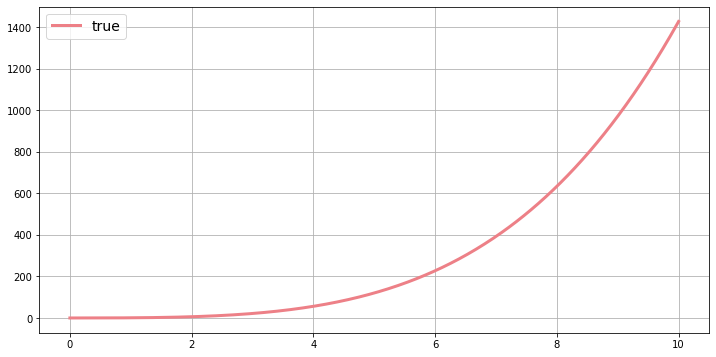

In [5]:
x = np.linspace(0, 10, 500)
y = np.array([
    weight[0] * (x**4) + 
    weight[1] * (x**3) + 
    weight[2] * (x**2) + 
    weight[3] * x +
    weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.grid(True)
ax.legend(fontsize=14)

plt.show()

## fitness funcs 

In [6]:
def fitnessCupy(weight, pop):
    out = cp.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        out[i] = cp.linalg.norm(weight-pop[i])
    return out

In [7]:
def fitnessNumpy(weight, pop):
    return np.linalg.norm(weight - pop, axis=1)

## parents func

In [8]:
def parentsNumpy(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.argmin(fitness)
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = np.inf
    return parents

## crossover func

In [9]:
def crossoverNumpy(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

## mutation func

In [10]:
def mutationNumpy(offspring_crossover):
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, 2] = offspring_crossover[idx, 2] + random_value

    return offspring_crossover

## example

In [11]:
t = time.time()
for _ in range(max_gen):
    fitness = fitnessNumpy(weight, new_pop)
    parents = parentsNumpy(new_pop, fitness, num_parents)
    offspring_crossover = crossoverNumpy(parents, offspring_size=(pop_size[0] - parents.shape[0], num_weight))
    offspring_mutation = mutationNumpy(offspring_crossover)
    new_pop[:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:, :] = offspring_mutation
time_cpu = round(time.time() - t, 2)

In [12]:
time_cpu

1.82

## visual true and predict polynom

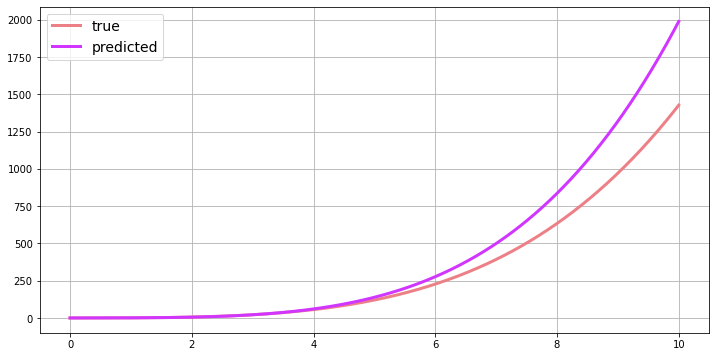

In [13]:
best_weight = new_pop[np.argmin(fitnessNumpy(weight, new_pop))]
y_pred = np.array([
    best_weight[0] * (x**4) + 
    best_weight[1] * (x**3) + 
    best_weight[2] * (x**2) + 
    best_weight[3] * x +
    best_weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.plot(x, y_pred, label='predicted', color='#d036ff', linewidth=3)
ax.grid(True)
ax.legend(fontsize=14)

plt.show()

## table best weight and true weight

In [14]:
data = pd.DataFrame(data={
    'best_weight': best_weight,
    'true_weight': weight
})

In [15]:
data

,best_weight,true_weight
0,0.181746,0.097627
1,0.148650,0.430379
2,0.205525,0.205527
3,0.304207,0.089766
4,-0.137163,-0.152690


## time statics

In [16]:
df = pd.DataFrame(data={
    'CPU':{
        'time':time_cpu,
        'gen':max_gen
    }
})

In [17]:
def fitnessTorch(weight, pop):
    out = torch.zeros(pop.shape[0]).cuda()
    for i in range(pop.shape[0]):
        out[i] = torch.linalg.norm(weight - pop[i]).cuda()
    return out

In [18]:
def parentsTorch(pop, fitness, num_parents):
    parents = torch.empty((num_parents, pop.shape[1])).cuda()
    for parent_num in range(num_parents):
        max_fitness_idx = torch.argmin(fitness)
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = 9e9
    return parents

In [19]:
def crossoverTorch(parents, offspring_size):
    offspring = torch.empty(offspring_size).cuda()
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

In [20]:
def mutationTorch(offspring_crossover):
    for idx in range(offspring_crossover.shape[0]):
        random_value = torch.randn(1).cuda()
        offspring_crossover[idx, 2] = offspring_crossover[idx, 2] + random_value

    return offspring_crossover

In [21]:
t = time.time()
weight = torch.from_numpy(weight).cuda()
new_pop = torch.from_numpy(new_pop).cuda()
for _ in range(max_gen):
    fitness = fitnessTorch(weight, new_pop)
    parents = parentsTorch(new_pop, fitness, num_parents)
    offspring_crossover = crossoverTorch(parents, offspring_size=(pop_size[0] - parents.shape[0], num_weight))
    offspring_mutation = mutationTorch(offspring_crossover)
    new_pop[:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:, :] = offspring_mutation
timeTorch = round(time.time() - t, 2)

In [22]:
timeTorch

38.57

NameError: name 'TrueTrue' is not defined

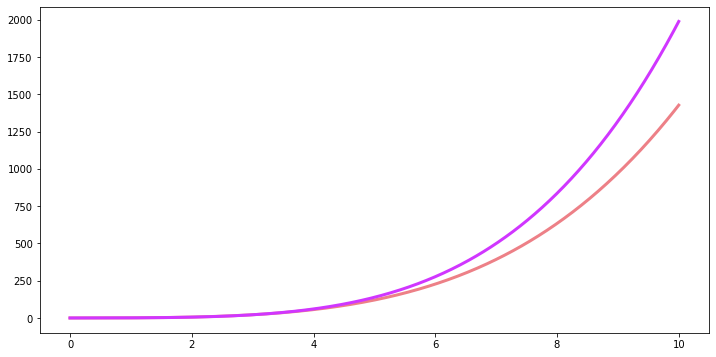

In [30]:
best_weight = new_pop[torch.argmin(fitnessTorch(weight, new_pop))]
y_pred = np.array([
    best_weight[0] * (x**4) + 
    best_weight[1] * (x**3) + 
    best_weight[2] * (x**2) + 
    best_weight[3] * x +
    best_weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.plot(x, y_pred, label='predicted', color='#d036ff', linewidth=3)
)ffigsize=14)

fig.show()